In [ ]:
import torch
import lib.utils.bookkeeping as bookkeeping
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import lib.models.models as models
import lib.models.model_utils as model_utils
import lib.datasets.datasets as datasets
import lib.datasets.dataset_utils as dataset_utils
import lib.losses.losses as losses
import lib.losses.losses_utils as losses_utils
import lib.training.training as training
import lib.training.training_utils as training_utils
import lib.optimizers.optimizers as optimizers
import lib.optimizers.optimizers_utils as optimizers_utils
import lib.loggers.loggers as loggers
import lib.loggers.logger_utils as logger_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils
import os
from lib.datasets.datasets import create_train_discrete_mnist_dataloader
from ruamel.yaml.scalarfloat import ScalarFloat

In [ ]:
# creating paths
path = 'SavedModels/MNIST/'
date = 'HRate001-2023-10-15'
config_name = 'config_001_rate001.yaml'
model_name = 'model_5999_rate001.pt' #ckpt_0000004999.pt'

config_path = os.path.join(path, date, config_name)
checkpoint_path = os.path.join(path, date, model_name)

In [ ]:
# creating models
cfg = bookkeeping.load_config(config_path)
print(type(cfg.sampler.corrector_entry_time))
cfg.sampler.name = 'ExactSampling' # LBJFSampling
cfg.logit_type = 'direct'
#cfg.sampler.corrector_entry_time = float(cfg.sampler.corrector_entry_time)
cfg.sampler.corrector_entry_time =ScalarFloat(0.1)
cfg.sampler.num_steps = 1
50
print(cfg)
device = torch.device(cfg.device)

model = model_utils.create_model(cfg, device)
print("number of parameters: ", sum([p.numel() for p in model.parameters()]))

#modified_model_state = utils.remove_module_from_keys(loaded_state['model'])
#model.load_state_dict(modified_model_state)
#optimizer = optimizers_utils.get_optimizer(model.parameters(), cfg)
optimizer = torch.optim.Adam(model.parameters(), cfg.optimizer.lr)

sampler = sampling_utils.get_sampler(cfg)

state = {"model": model, "optimizer": optimizer, "n_iter": 0}
state = bookkeeping.load_state(state, checkpoint_path)
state['model'].eval()

In [4]:

n_samples = 9
samples = sampler.sample(model, n_samples, 10)
samples = samples.reshape(n_samples, 1, cfg.data.image_size, cfg.data.image_size)

150it [55:01, 22.01s/it]


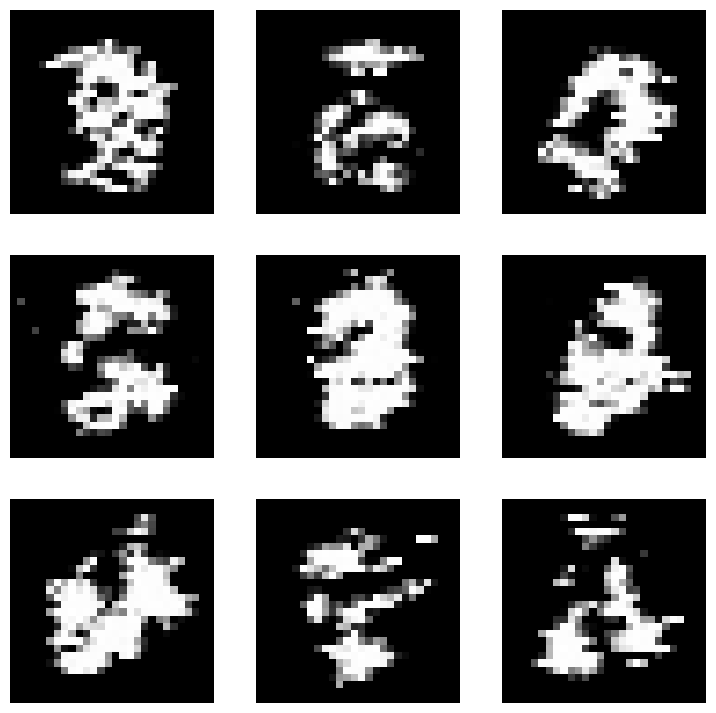

In [5]:
saving_train_path = os.path.join(cfg.saving.sample_plot_path, f"eval_samples_hollow_{state['n_iter']}.png")
fig = plt.figure(figsize=(9, 9))  
for i in range(n_samples):
    plt.subplot(int(np.sqrt(n_samples)), int(np.sqrt(n_samples)), 1 + i)
    plt.axis("off")
    plt.imshow(np.transpose(samples[i, ...], (1,2,0)), cmap="gray")


plt.savefig(saving_train_path)
plt.show()
plt.close()